 * Generate dozen datapoints, render pairs of raw pygame images and processed ones
 * Fix robot orientation, angles, rendering
 * Generate 10k and 100k datasets, save as 'random-dataset10k.pickle' and 'random-dataset100k.pickle'

In [2]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib

In [45]:
from env import ArmRobotEnv
env = ArmRobotEnv()

## Visualize relationships between actuators and robot poses

In [29]:
N = 3
a_space = np.linspace(-1., 1., N)

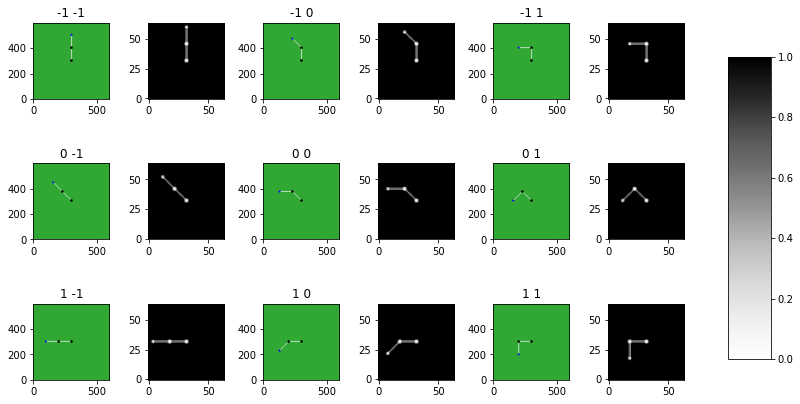

In [37]:
fig, axs = plt.subplots(N, N*2, figsize=(12, 6))
fig.tight_layout()
col_map = plt.get_cmap('Greys')

for i in range(N):
    for j in range(N):
        env.env.step([a_space[i], a_space[j]])
        env.env.render()        
        raw_img_array = env.get_raw_image()
        img_array = env.get_image()
        
        axs[i][2*j].title.set_text("%d %d" % (a_space[i], a_space[j]))
        axs[i][2*j].imshow(raw_img_array, origin='lower')

        assert((len(img_array.shape) == 3) and img_array.shape[2] == 1) ## (D, D, C=1)
        last_im = axs[i][2*j+1].imshow(img_array[...,0], cmap=col_map, origin='lower')

# https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
_ = fig.colorbar(last_im, cax=cbar_ax)

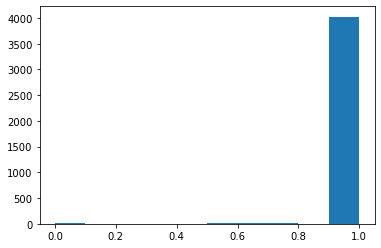

In [38]:
_ = plt.hist(img_array.flatten())

## Generate 100k datapoints for training, 100 for testing and 100 for validation

In [48]:
import time

def gen_data(N):
    """
    Generate testdata: actions and robot views
    """
    env.reset()

    print("Generating %d datapoints ... (approx %f sec)" % (N, N*0.035)) # FIXME
    
    start_time = time.time()
    for i in range(N):
        action = env.env.action_space.sample()
        obs, _reward, _done, _info = env.step(action)
        env.render()
        y = env.get_image()
        
        if i == 0:
            A = np.zeros([N] + list(action.shape))
            Y = np.zeros([N] + list(y.shape))

        A[i] = action.flatten()
        Y[i] = y
  
    elapsed = time.time() - start_time
    print("Generated %d data points. Actual time: %.1fs (%f sec/datapoint)" % (N, elapsed, elapsed/N))

    return A, Y

In [66]:
# 100'000 train, 100 test, 100 validate
train_A, train_Y = gen_data(100000)
test_A, test_Y = gen_data(100)
val_A, val_Y = gen_data(100)

Generating 100000 datapoints ... (approx 3500.000000 sec)
Generated 100000 data points. Actual time: 3202.1s (0.032021 sec/datapoint)
Generating 100 datapoints ... (approx 3.500000 sec)
Generated 100 data points. Actual time: 3.2s (0.032070 sec/datapoint)
Generating 100 datapoints ... (approx 3.500000 sec)
Generated 100 data points. Actual time: 3.2s (0.032070 sec/datapoint)


### Load

In [6]:
import pickle
with open('dataset-random-100k.pickle', 'rb') as handle:
    [train_A, train_Y, test_A, test_Y, val_A, val_Y] = pickle.load(handle)
print(train_Y.shape)

(100000, 64, 64, 1)


## Save

In [70]:
import pickle

with open('dataset-random-100k.pickle', 'wb') as handle:
    pickle.dump([train_A, train_Y, test_A, test_Y, val_A, val_Y], handle, protocol=pickle.HIGHEST_PROTOCOL)

## Visualize

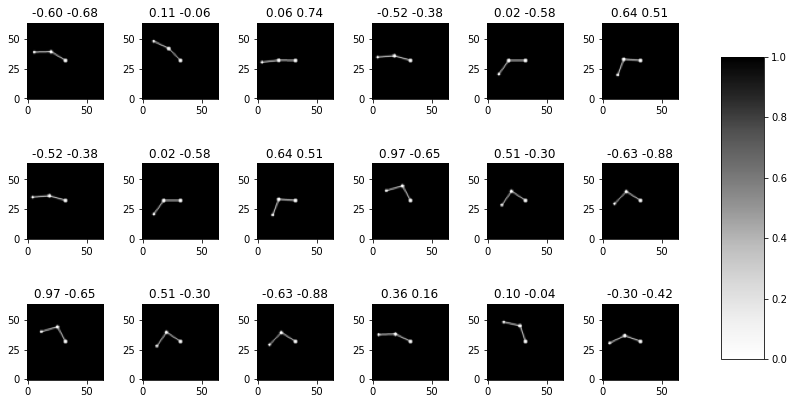

In [8]:
N = 3
M = 6

fig, axs = plt.subplots(N, M, figsize=(12, 6))
fig.tight_layout()
col_map = plt.get_cmap('Greys')

for i in range(N):
    for j in range(M):
        k = i*N+j
        img_array = train_Y[k]
        assert((len(img_array.shape) == 3) and img_array.shape[2] == 1) ## (D, D, C=1)
        axs[i][j].title.set_text("%.2f %.2f" % (val_A[k,0], val_A[k,1]))
        last_im = axs[i][j].imshow(img_array[...,0], cmap=col_map, origin='lower')

# https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
_ = fig.colorbar(last_im, cax=cbar_ax)